# Krakowskie pochówki

## Wstęp o danych i Covidzie

Dobrych parę lat temu zmagaliśmy się z pandemią COVID 19. Kolejne obostrzenia, niepokojące wydarzenia i zwykła ciekawość prowadziły do zwiększonego zainteresowania wykresami zachorowań i zgonów. Sam poszukiwałem sensownych i ciekawych statystyk.
Najczęściej zaglądałem na stronę [koronawirusunas.pl](https://koronawirusunas.pl/), ponieważ znajdują się tam w jednym miejscu wyniki dla całego kraju.

<div class="alert alert-block alert-success">
  <strong>Luźne uwagi:</strong> 
  
Wykresy dotyczące zachorowań na COVID19:
- przedstawiają wyniki testów, na co wpływała dostępność testów, uznaniowość w testowaniu czy ich jakość;
- cechują się okresowością wynikająca z działania systemu i laboratoriów, a przecież zachorowania nie znają tygodniowej sezonowości;
- nie były w pełni aktualne - czasami zdarzały się aktualizacje historycznych danych, spore wrzutki związane z opóźnieniami.

Natomiast statystyki zgonów na COVID19:
- występują z opóźnieniem względem zachorowań;
- cechują się pewną uznaniowością (kwestia definicji), czy dany zgon kwalifikuje się jako covidowy;
- czasami spływały dłużej i były aktualizowane (podobnie jak zachorowań).
</div>


Próbowałem poszukać też danych o zgonach na stronach rządowych. Statystyki krajowe znalazłem na stronie [stats gov](https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/zgony-wedlug-tygodni-oraz-wieku-plci-zmarlych-i-73-podregionow-w-2023-roku,39,24.html). Według mnie ich cechy to:
- trudny format do obróbki danych i rozproszenie plików,
- rozdzielczość tygodniowa z opóźnioną publikacją.

Dla innych europejskich krajów są choćby dane dostępne na stronie [EuroMOMO](https://www.euromomo.eu/graphs-and-maps). Nadwyżki zgonów i kategorie wiekowe są tam ładnie zwizualizowane. Dane pojawiają się w miarę na bieżąco w rozdzielczości tygodniowej, ale trzeba pamiętać, że mogą być wstecznie poprawiane (jak każde dane w czasie, które napływają z raportów).

Poszukując innych źródeł sprawdzonych danych natrafiłem na stronę [cmentarzy komunalnych w Krakowie](https://zck-krakow.pl/funerals). Dane o pogrzebach są publikowane przed pogrzebem i można również przejrzeć kilkuletnią historię. Dla dość dużego miasta jakim jest Kraków codziennie pojawia się kilkanaście wpisów, co jest wystarczające do przeprowadzenia ciekawych analiz. Poza samym faktem zaistnienia pochówku dostajemy również informację o wieku zmarłego i płci (z imienia i nazwiska). To pozwala uzyskać interesujące wykresy.

<div class="alert alert-block alert-success">
  <strong>Informacje o pochówkach</strong> 

- są dość aktualne (aczkolwiek zebranie pochówków dodanych danego dnia wymaga więcej pracy, w szczególności zbierania danych na bieżąco),
- są dość dokładne (imię, nazwisko, wiek),
- nie ulegają zmianom - z moich obserwacji wynika, że dane historyczne raczej się nie zmieniają,
- rzadko zawierają błędy - głównie _litrówki_,
- okazjonalnie dotyczą nietypowych wydarzeń, np. przeniesienie cmentarza cholerycznego.
</div>


## Analiza danych

Najtrudniejszą dla mnie częścią techniczną było _scrape'owanie_ danych ze strony, do czego użyłem bibliotek _Selenium_ (wraz z _ChromeDriver'em_) i _BeautifulSoup_. Na razie nie udostępniam tego kodu, natomiast przygotowałem zebrane dane w plikach. 
W analizie nieocenione okazały się biblioteki _pandas_, _matplotlib_ i _plotly_.

In [5]:
import pandas as pd
import pylab as plt
import matplotlib.dates as mdates

In [6]:
# Ładowanie zapisanych danych
df = pd.read_csv("dane_zck.csv",index_col = 0)
df.index = pd.to_datetime(df.index)
dfAge = pd.read_csv("age_gender.csv", index_col = 0)
dfAge.datum = pd.to_datetime(dfAge.datum)

Bazuję na dwóch plikach (dane_zck.csv i age_gender.csv) załadowanych do pandasowych DataFrame'ów.
Pierwszy z nich zawiera liczbę pogrzebów na dany dzień. Drugi dotyczy daty, wieku zmarłego i płci (wnioskowanej przez obecność 'a' na końcu imienia).  
Łącznie mam do dyspozycji ok. 40 tys. wpisów w latach 2018-2024. Pogrzeby w weekendy i święta są wyjątkami - zdarzały się głównie w covidzie.

In [7]:
df.head()

,person
datum,
2018-05-02,18.0
2018-05-03,0.0
2018-05-04,29.0
2018-05-05,1.0
2018-05-06,0.0


In [8]:
dfAge.head()

,datum,age,female
0,2024-08-01,91,True
1,2024-08-01,86,True
2,2024-08-01,72,False
3,2024-08-01,94,False
4,2024-08-01,82,False


### Sumaryczne wyniki dla poszczególnych lat

Poniżej prezentuję posumowane wyniki dla każdego roku z osobna. Ze względu na niepełne dane dla lat 2018 i 2024 pozwoliłem sobie z proporcji wyliczyć szacowaną roczną liczbę pogrzebów z uwzględnieniem dostępnych dni. Łatwo zauważyć, że covidowe lata 2020, 2021 i  2022 wybijają się ponad resztę.

In [9]:
count = (df.groupby(df.index.year).mean()*365).map(lambda x: f"{x:.1f}")
count = count.reset_index().rename(columns = {"datum":"rok", "person": "pogrzeby (średnia)"}).set_index("rok").map(lambda x: float(x))

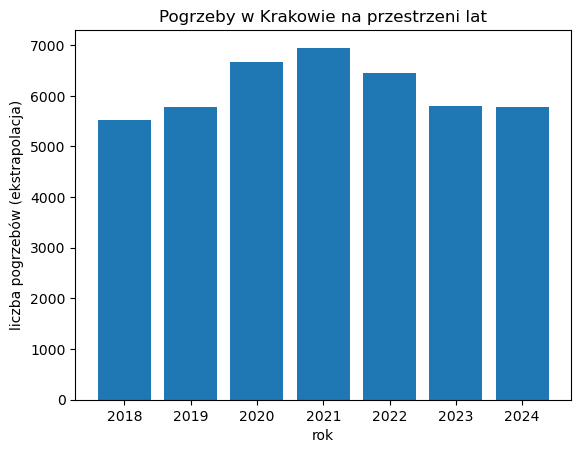

In [10]:
plt.title("Pogrzeby w Krakowie na przestrzeni lat")
plt.bar(count.index.to_numpy(), count["pogrzeby (średnia)"].to_numpy())
plt.xlabel('rok')
plt.ylabel("liczba pogrzebów (ekstrapolacja)");

### Miesięczne porównania dla poszczególnych lat

Przejdźmy do większej rozdzielczości. Dane dzienne są zaszumione i pojawiają się puste dni ze względu na święta i weekendy. Z tego powodu wykorzystuję dwukrotnie średnią kroczącą (7- i 28-dniową). Jest to mój subiektywny wybór - uznałem, że w takim podejściu krzywa jest najbardziej czytelna i minimalizuje wpływ zerowych dni.

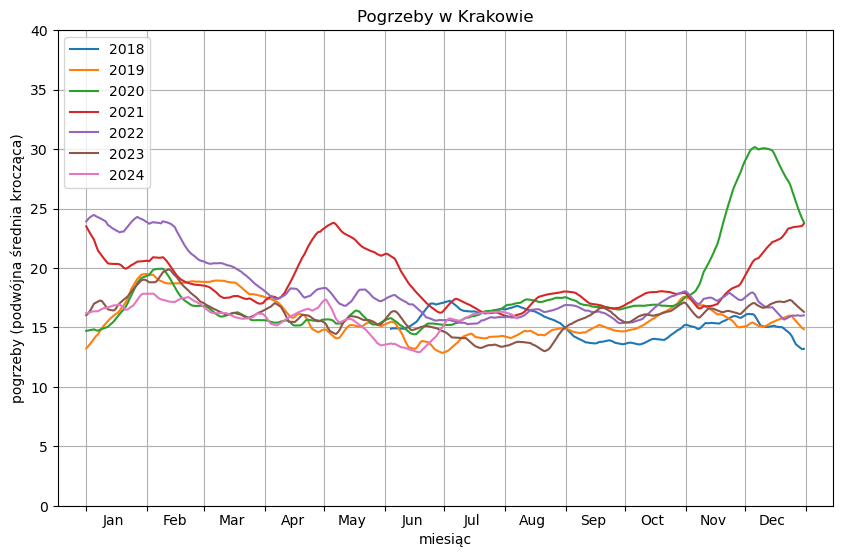

In [11]:
fig = plt.figure(figsize=(10,10/1.618))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', which='minor') 

for dd in df.rolling(window = 7).mean().rolling(window = 28).mean().groupby(df.index.year):
    DF = dd[1]
    DF.index = DF.index.map(lambda x: x - pd.DateOffset(year=2000))
    plt.plot(DF.person, label = dd[0])

ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.tick_params(which='minor',width=0)
ax.margins(0.04,0.0)
plt.legend()
plt.title("Pogrzeby w Krakowie")
plt.xlabel('miesiąc')
plt.ylabel('pogrzeby (podwójna średnia krocząca)')
plt.ylim([0,40])
plt.grid();

Zauważamy fale covidowe w latach 2020-2022. Widać też niewielką sezonowość dla pełnych lat niecovidowych 2019 i 2023. W okresie zimowym występuje więcej pogrzebów.  
Do podobnych wniosków dochodzimy analizując wykres na całej osi czasu:

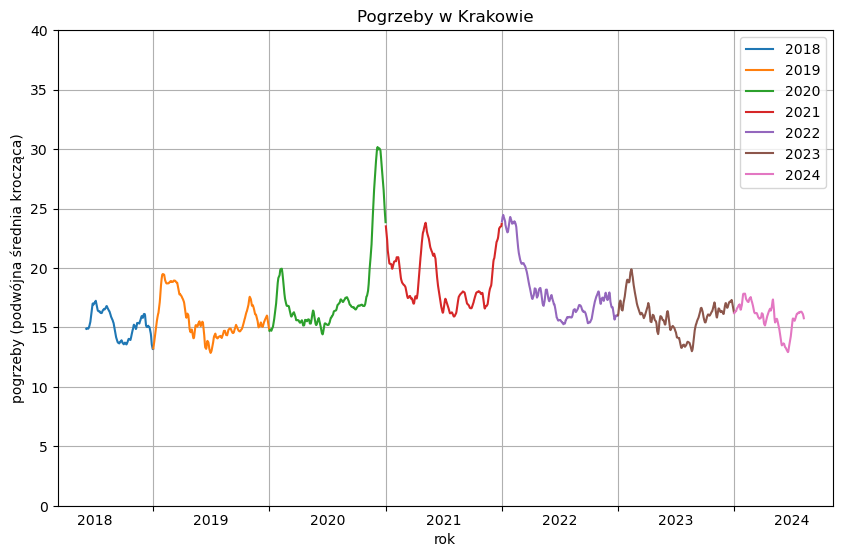

In [12]:
fig = plt.figure(figsize=(10,10/1.618))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', which='minor') 

for dd in df.rolling(window = 7).mean().rolling(window = 28).mean().groupby(df.index.year):
    DF = dd[1]
    plt.plot(DF.person, label = dd[0])

ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
ax.xaxis.set_major_locator(mdates.YearLocator(month=1))
ax.xaxis.set_minor_locator(mdates.YearLocator(month=7))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))
ax.tick_params(which='minor',width=0)
ax.margins(0.04,0.0)
plt.legend()
plt.title("Pogrzeby w Krakowie")
plt.xlabel('rok')
plt.ylabel('pogrzeby (podwójna średnia krocząca)')
plt.ylim([0,40])
plt.grid();

### Histogramy dla wieku i płci

Kolejne na tapet lądują dane o płci i wieku. Łatwo dostrzec prawidłowość, że kobiety żyją dłużej. Wśród dzieci zgony przeważają dla noworodów i niemowląt.

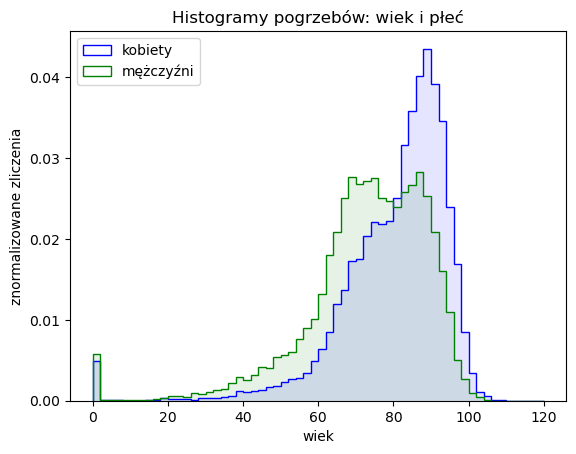

In [13]:
plt.hist(dfAge[dfAge.female==True ].age,range = (0,120),bins = 60, histtype="step", density=True, color = 'blue', label='kobiety');
plt.hist(dfAge[dfAge.female==False ].age,range = (0,120),bins = 60, histtype="step", density=True, color = 'green',label = "mężczyźni");
plt.hist(dfAge[dfAge.female==True ].age,range = (0,120),bins = 60, histtype="stepfilled", density=True, color = 'blue',  alpha=0.1);
plt.hist(dfAge[dfAge.female==False ].age,range = (0,120),bins = 60, histtype="stepfilled", density=True, color = 'green', alpha=0.1);
plt.title("Histogramy pogrzebów: wiek i płeć")
plt.xlabel("wiek")
plt.ylabel("znormalizowane zliczenia")
plt.legend();

Prezentuję również histogramy dla kobiet z podziałem na lata. Nie zauważam większych różnic poza rokiem 2019 i zgonami najmłodszych.

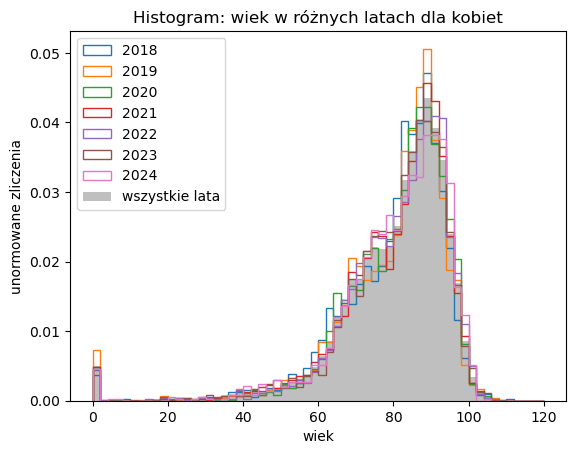

In [14]:
for year in range(2018,2024+1):
    plt.hist(dfAge[(dfAge.female==True) & dfAge.datum.apply(lambda x: x.year==year)].age,range = (0,120),bins = 60, histtype="step",label=year, density=True);
plt.hist(dfAge[(dfAge.female==True) ].age,range = (0,120),bins = 60, histtype="stepfilled",color='grey', alpha = 0.5, label = 'wszystkie lata', density=True);
plt.legend();
plt.title("Histogram: wiek w różnych latach dla kobiet")
plt.xlabel("wiek")
plt.ylabel("unormowane zliczenia");

### Porównanie z populacją kraju

Dodatkowo warto wyliczyć różne statystyki i porównać je z danymi dotyczącymi całego kraju albo skonfrontować je z innymi źródłami odnoszącymi się do Krakowa.

In [15]:
19_763/38_265

0.5164771984842546

Sprawdźmy, czy kobiety stanowią taki sam procent grupy jak w populacji. Dla całej Polski na kobietę przypada średnio 0.94 mężczyzny, co przekłada się na 51.65% społeczeństwa [źródło](https://wikipedia.org). W moich danych doliczam się 20273 kobiet na 39010 wpisów. Niestety mogłem nie odfiltrować wszystkich niepoprawnych przypadków i metoda podziału ze względu na płeć nie sprawdza się dla zagranicznych imion. Korzystając z testu binomialnego w bibliotece _scipy_ wyliczam p-wartość, która wynosi 0.21. To oznacza, że przy poziomie istotności 0.05 nie ma podstaw do odrzucenia hipotezy zerowej. Zatem upraszczając - pogrzebowa próbka danych ma ten sam udział procentowy kobiet co w populacji Polski.  
Nb. fakt, że kobiety żyją dłużej nie wpływa na tę statystykę.

In [22]:
from scipy.stats import binomtest
women = int((dfAge.female==True).sum())
people = dfAge.female.count()
pPopulation = 0.5165
binomtest(women, people, pPopulation, alternative='two-sided')

BinomTestResult(k=20273, n=39010, alternative='two-sided', statistic=0.5196872596770059, pvalue=0.2090000676606138)

## Podsumowanie

Przedstawiłem szczegółową analizę pogrzebów w Krakowie. Wykonałem sporo technicznej pracy, aby przygotować dane i wykresy, które ilustrują różne aspekty tego zagadnienia. Porównałem również wyniki z danymi dotyczącymi populacji całego kraju. Oczywiście można jeszcze sporo pracy wykonać, m.in. dopracować model uśredniania czy przeprowadzić dogłębniejszą analizę histogramów i statystyk.